# EDA Completo - Sistema de Homologación de Medicamentos

Este notebook realiza un **Análisis Exploratorio de Datos (EDA) completo** para el diseño de un sistema de homologación automática de medicamentos.

## Objetivos:
- 🔍 Identificar variables clave para homologación
- 📊 Evaluar calidad y cobertura de datos
- 🎯 Analizar medicamentos válidos vs inválidos
- 💡 Generar recomendaciones para el modelo

## Estructura:
1. **Configuración y Carga de Datos**
2. **Preprocesamiento y Unificación**
3. **Análisis Exploratorio Detallado**
4. **Análisis de Cobertura para Homologación**
5. **Visualizaciones y Conclusiones**

## 1. Configuración Inicial y Carga de Datos

### 1.1 Importación de Librerías

Importamos todas las librerías necesarias para el análisis:

In [53]:
# Librerías de sistema y utilidades
import os
from typing import Dict

# Librerías para manejo de datos
import polars as pl
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt

# Librerías para widgets interactivos
import ipywidgets as widgets
from IPython.display import display, clear_output

# Variables globales
rutas_archivos = {}

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


### 1.2 Función para Carga Interactiva de Archivos

Esta función permite cargar múltiples archivos de manera interactiva usando widgets:

In [54]:
def preparar_uploader(dest_dir, nombres_base):
    """
    Genera widgets de carga de archivos individuales que detectan automáticamente 
    la extensión del archivo subido y lo guardan con el nombre base especificado.
    
    Args:
        dest_dir (str): Ruta del directorio destino donde se guardarán los archivos
        nombres_base (list): Lista de strings con los nombres base para cada archivo
    
    Returns:
        None: Los resultados se almacenan en la variable global 'rutas_archivos'
    """
    global rutas_archivos
    
    if not nombres_base:
        print("⚠️ Lista vacía")
        return

    os.makedirs(dest_dir, exist_ok=True)
    rutas_archivos.clear()
    elementos = []

    for idx, nombre_base in enumerate(nombres_base):
        label = widgets.Label(f"🗂️ {idx+1}. Cargar '{nombre_base}'")
        uploader = widgets.FileUpload(accept='*', multiple=False)
        output = widgets.Output()

        def on_upload(change, nombre_base=nombre_base, output=output):
            with output:
                clear_output()
                try:
                    archivos = change['new']
                    
                    if not archivos:
                        print("❌ No hay archivos en change")
                        return
                    
                    # Obtener información del archivo
                    if isinstance(archivos, dict):
                        fileinfo = list(archivos.values())[0]
                    elif isinstance(archivos, (list, tuple)) and len(archivos) > 0:
                        fileinfo = archivos[0]
                    else:
                        print(f"❌ Tipo de archivo no reconocido: {type(archivos)}")
                        return
                        
                    nombre_original = fileinfo['name']
                    contenido = fileinfo['content']
                    
                    # Detectar extensión y crear nombre final
                    extension = os.path.splitext(nombre_original)[1]
                    nombre_final = f"{nombre_base}{extension}"
                    ruta_completa = os.path.join(dest_dir, nombre_final)
                    
                    # Crear directorio y guardar archivo
                    os.makedirs(dest_dir, exist_ok=True)
                    with open(ruta_completa, 'wb') as f:
                        f.write(contenido)
                    
                    # Actualizar diccionario global
                    rutas_archivos[nombre_base] = ruta_completa
                    
                    print(f"✅ {nombre_original} → {nombre_final}")
                    
                except Exception as e:
                    print(f"❌ Error: {type(e).__name__}: {str(e)}")

        uploader.observe(on_upload, names='value')
        elementos.append(widgets.VBox([label, uploader, output]))

    display(widgets.VBox(elementos))
    print(f"📁 Guardando en: {dest_dir}")

### 1.3 Carga de Archivos de Medicamentos

Cargamos los 4 archivos principales del dataset de medicamentos:

In [55]:
# Configurar archivos a cargar
ruta_destino = "./data/"
archivos_medicamentos = [
    "medicametos_vencidos", 
    "medicamentos_vigentes", 
    "medicamentos_renovacion",
    "medicamentos_otros"
]

# Ejecutar carga interactiva
preparar_uploader(ruta_destino, archivos_medicamentos)

# Verificar rutas después de la carga
print("\n📋 Rutas de archivos cargados:")
for nombre, ruta in rutas_archivos.items():
    print(f"   {nombre}: {ruta}")

📁 Guardando en: ./data/

📋 Rutas de archivos cargados:


### 1.4 Carga Alternativa (Si ya tienes los archivos)

Si ya tienes los archivos en el directorio, puedes usar esta celda para definir las rutas manualmente:

In [56]:
# Rutas alternativas (descomenta si ya tienes los archivos)
rutas_archivos = {
    'medicametos_vencidos': './data/medicametos_vencidos.xlsx', 
    'medicamentos_vigentes': './data/medicamentos_vigentes.xlsx', 
    'medicamentos_renovacion': './data/medicamentos_renovacion.xlsx', 
    'medicamentos_otros': './data/medicamentos_otros.xlsx'
}

print("📋 Rutas de archivos configuradas:")
for nombre, ruta in rutas_archivos.items():
    existe = "✅" if os.path.exists(ruta) else "❌"
    print(f"   {existe} {nombre}: {ruta}")

📋 Rutas de archivos configuradas:
   ✅ medicametos_vencidos: ./data/medicametos_vencidos.xlsx
   ✅ medicamentos_vigentes: ./data/medicamentos_vigentes.xlsx
   ✅ medicamentos_renovacion: ./data/medicamentos_renovacion.xlsx
   ✅ medicamentos_otros: ./data/medicamentos_otros.xlsx


## 2. Preprocesamiento y Unificación de Datos

### 2.1 Lectura de Archivos Excel

Cargamos cada archivo como un DataFrame de Polars:

In [57]:
# Leer todos los archivos Excel
try:
    df_medicametos_vencidos = pl.read_excel(rutas_archivos['medicametos_vencidos'])
    df_medicamentos_vigentes = pl.read_excel(rutas_archivos['medicamentos_vigentes'])
    df_medicamentos_renovacion = pl.read_excel(rutas_archivos['medicamentos_renovacion'])
    df_medicamentos_otros = pl.read_excel(rutas_archivos['medicamentos_otros'])
    
    print("✅ Archivos leídos correctamente:")
    print(f"   📊 Medicamentos vencidos: {df_medicametos_vencidos.shape[0]:,} filas")
    print(f"   📊 Medicamentos vigentes: {df_medicamentos_vigentes.shape[0]:,} filas")
    print(f"   📊 Medicamentos renovación: {df_medicamentos_renovacion.shape[0]:,} filas")
    print(f"   📊 Medicamentos otros: {df_medicamentos_otros.shape[0]:,} filas")
    
except Exception as e:
    print(f"❌ Error leyendo archivos: {e}")
    print("💡 Verifica que los archivos existan en las rutas especificadas")

Could not determine dtype for column 28, falling back to string
Could not determine dtype for column 5, falling back to string
Could not determine dtype for column 5, falling back to string
Could not determine dtype for column 28, falling back to string
Could not determine dtype for column 28, falling back to string
Could not determine dtype for column 28, falling back to string
Could not determine dtype for column 28, falling back to string


✅ Archivos leídos correctamente:
   📊 Medicamentos vencidos: 154,187 filas
   📊 Medicamentos vigentes: 154,320 filas
   📊 Medicamentos renovación: 2,133 filas
   📊 Medicamentos otros: 96,167 filas


### 2.2 Validación de Esquemas

Verificamos que todos los DataFrames tengan las mismas columnas y tipos de datos:

In [58]:
# Verificar columnas de cada DataFrame
dataframes = [
    ("df_medicametos_vencidos", df_medicametos_vencidos),
    ("df_medicamentos_vigentes", df_medicamentos_vigentes),
    ("df_medicamentos_renovacion", df_medicamentos_renovacion),
    ("df_medicamentos_otros", df_medicamentos_otros)
]

print("🔍 COLUMNAS POR DATASET:")
print("="*80)
for nombre, df in dataframes:
    print(f"\n📋 {nombre}:")
    print(" | ".join(df.columns))

# Verificar compatibilidad
columnas_iguales = all(df.columns == dataframes[0][1].columns for _, df in dataframes[1:])
tipos_iguales = all(df.dtypes == dataframes[0][1].dtypes for _, df in dataframes[1:])

print(f"\n✅ ¿Todas las columnas son iguales?: {columnas_iguales}")
print(f"✅ ¿Todos los tipos de datos son iguales?: {tipos_iguales}")

if columnas_iguales and tipos_iguales:
    print("🎉 Los DataFrames son compatibles para unificación")
else:
    print("⚠️ Los DataFrames requieren homologación antes de unificar")

🔍 COLUMNAS POR DATASET:

📋 df_medicametos_vencidos:
EXPEDIENTE | PRODUCTO | TITULAR | REGISTRO SANITARIO | FECHA EXPEDICION | FECHA VENCIMIENTO | ESTADO REGISTRO | EXPEDIENTE CUM | CONSECUTIVO | CANTIDAD CUM | DESCRIPCIÓN COMERCIAL | ESTADO CUM | FECHA ACTIVO | FECHA INACTIVO | MUESTRA MÉDICA | UNIDAD | ATC | DESCRIPCIÓN_ATC | VÍA ADMINISTRACIÓN | CONCENTRACIÓN | PRINCIPIO ACTIVO | UNIDAD MEDIDA | CANTIDAD | UNIDAD REFERENCIA | FORMA FARMACÉUTICA | NOMBRE ROL | TIPO ROL | MODALIDAD | IUM

📋 df_medicamentos_vigentes:
EXPEDIENTE | PRODUCTO | TITULAR | REGISTRO SANITARIO | FECHA EXPEDICION | FECHA VENCIMIENTO | ESTADO REGISTRO | EXPEDIENTE CUM | CONSECUTIVO | CANTIDAD CUM | DESCRIPCIÓN COMERCIAL | ESTADO CUM | FECHA ACTIVO | FECHA INACTIVO | MUESTRA MÉDICA | UNIDAD | ATC | DESCRIPCIÓN_ATC | VÍA ADMINISTRACIÓN | CONCENTRACIÓN | PRINCIPIO ACTIVO | UNIDAD MEDIDA | CANTIDAD | UNIDAD REFERENCIA | FORMA FARMACÉUTICA | NOMBRE ROL | TIPO ROL | MODALIDAD | IUM

📋 df_medicamentos_renovacion:
EXPEDI

### 2.3 Unificación de DataFrames

Unimos todos los DataFrames en uno solo, añadiendo una columna identificadora del origen:

In [59]:
if columnas_iguales and tipos_iguales:
    # Añadir columna identificadora del dataset origen
    df_medicametos_vencidos = df_medicametos_vencidos.with_columns(
        pl.lit("medicametos_vencidos").alias("DATASET")
    )
    df_medicamentos_vigentes = df_medicamentos_vigentes.with_columns(
        pl.lit("medicamentos_vigentes").alias("DATASET")
    )
    df_medicamentos_renovacion = df_medicamentos_renovacion.with_columns(
        pl.lit("medicamentos_renovacion").alias("DATASET")
    )
    df_medicamentos_otros = df_medicamentos_otros.with_columns(
        pl.lit("medicamentos_otros").alias("DATASET")
    )

    # Unir todos los DataFrames
    df_unido = pl.concat([
        df_medicametos_vencidos,
        df_medicamentos_vigentes,
        df_medicamentos_renovacion,
        df_medicamentos_otros
    ])
    
    print("✅ DataFrames unidos correctamente")
    print(f"📊 Dataset unificado: {df_unido.shape[0]:,} filas × {df_unido.shape[1]} columnas")
    
else:
    print("❌ No se puede unir automáticamente. Revisar esquemas manualmente.")

✅ DataFrames unidos correctamente
📊 Dataset unificado: 406,807 filas × 30 columnas


In [77]:
# Buscar medicamentos que contengan "acetamino" en el principio activo
df_unido.filter(
    pl.col("PRINCIPIO ACTIVO").str.contains("(?i)acetamino")
).select("PRINCIPIO ACTIVO").unique().sort("PRINCIPIO ACTIVO")

PRINCIPIO ACTIVO
str
"""**ACETAMINOFÉN COMPAP WSE 95% …"
"""**COMPRESO PAP 90 CPF 361.11 M…"
"""361.11 MG DE ACETAMINOFEN DC 9…"
"""361.11 MG DE ACETAMINOFENUSP A…"
"""361.12 MG DE ACETAMINOFEN COMP…"
…
"""COMPAP®L 561.39 MG EQUIVALENTE…"
"""GRANULOS DE ACETAMINOFEN CD 87…"
"""MEZCLA PARA COMPRESION DIRECTA…"


### 2.4 Transformaciones y Selección de Campos

Creamos el identificador CUM y seleccionamos las columnas más relevantes para el análisis:

In [60]:
# Crear la columna "CUM" concatenando EXPEDIENTE CUM y CONSECUTIVO
df_unido = df_unido.with_columns(
    (pl.col("EXPEDIENTE CUM").cast(pl.Utf8) + pl.lit("-") + pl.col("CONSECUTIVO").cast(pl.Utf8)).alias("CUM")
)

# Seleccionar y reordenar columnas relevantes
df_unido = df_unido.sort("CUM", descending=True).select([
    'CUM',
    'PRODUCTO',
    'EXPEDIENTE CUM',
    'ATC',
    'DESCRIPCIÓN_ATC',
    'VÍA ADMINISTRACIÓN',
    'CANTIDAD CUM',
    'PRINCIPIO ACTIVO',
    'UNIDAD MEDIDA',
    'CANTIDAD',
    'UNIDAD REFERENCIA',
    'FORMA FARMACÉUTICA',
    'ESTADO REGISTRO',
    'ESTADO CUM',
    'MUESTRA MÉDICA',
]).unique().sort("CUM")

# Crear columna indicadora de validez
df_unido = df_unido.with_columns(
    ((pl.col('ESTADO REGISTRO') == 'Vigente') & 
     (pl.col('ESTADO CUM') == 'Activo') & 
     (pl.col('MUESTRA MÉDICA') == 'No')).cast(pl.Int8).alias('VALIDO')
)

# Reordenar columnas finales
df_preproc = df_unido.select([
    'CUM',
    'PRODUCTO',
    'EXPEDIENTE CUM',
    'ATC',
    'DESCRIPCIÓN_ATC',
    'VÍA ADMINISTRACIÓN',
    'PRINCIPIO ACTIVO',
    'FORMA FARMACÉUTICA',
    'CANTIDAD CUM',
    'CANTIDAD',
    'UNIDAD MEDIDA',
    'VALIDO',
    'ESTADO REGISTRO',
    'ESTADO CUM',
    'MUESTRA MÉDICA'
])

print("✅ Transformaciones completadas")
print(f"📊 Dataset final: {df_preproc.shape[0]:,} filas × {df_preproc.shape[1]} columnas")
print(f"🔍 Muestra del dataset:")
display(df_preproc.head())

✅ Transformaciones completadas
📊 Dataset final: 248,635 filas × 15 columnas
🔍 Muestra del dataset:


CUM,PRODUCTO,EXPEDIENTE CUM,ATC,DESCRIPCIÓN_ATC,VÍA ADMINISTRACIÓN,PRINCIPIO ACTIVO,FORMA FARMACÉUTICA,CANTIDAD CUM,CANTIDAD,UNIDAD MEDIDA,VALIDO,ESTADO REGISTRO,ESTADO CUM,MUESTRA MÉDICA
str,str,i64,str,str,str,str,str,f64,f64,str,i8,str,str,str
"""10042-1""","""FLUNARICINA 10 MG""",10042,"""N07CA03""","""FLUNARIZINA""","""ORAL""","""FLUNARICINA""","""TABLETA""",20.0,10.0,"""mg""",0,"""Vencido""","""Inactivo""","""No"""
"""10045-1""","""IBUPROFENO 500 MG TABLETAS""",10045,"""M01AE01""","""IBUPROFENO""","""ORAL""","""IBUPROFENO""","""TABLETA""",10.0,400.0,"""mg""",0,"""Vencido""","""Inactivo""","""No"""
"""10045-2""","""IBUPROFENO 500 MG TABLETAS""",10045,"""M01AE01""","""IBUPROFENO""","""ORAL""","""IBUPROFENO""","""TABLETA""",30.0,400.0,"""mg""",0,"""Vencido""","""Inactivo""","""No"""
"""100454-1""","""CLOTRIMAZOL 100 MG""",100454,"""G01AF02""","""CLOTRIMAZOL""","""VAGINAL""","""CLOTRIMAZOL""","""TABLETA VAGINAL""",6.0,100.0,"""mg""",0,"""Vencido""","""Inactivo""","""No"""
"""100458-1""","""DICLOFENACO 50 MG TABLETAS""",100458,"""M01AB05""","""DICLOFENACO""","""ORAL""","""DICLOFENACO SÓDICO""","""TABLETA CUBIERTA CON PELICULA""",100.0,50.0,"""mg""",0,"""Vencido""","""Inactivo""","""No"""


## 3. Análisis Exploratorio de Datos Detallado

### 3.1 Ejecución del Análisis Exploratorio

Ejecutamos el análisis completo sobre nuestro dataset preprocesado:

In [ ]:
# ANÁLISIS DE INFORMACIÓN GENERAL DEL DATASET
# ============================================================================

print("="*60)
print("📊 INFORMACIÓN GENERAL DEL DATASET")
print("="*60)

filas, columnas = df_preproc.shape
memoria_mb = df_preproc.estimated_size() / (1024**2)

print(f"📏 Dimensiones: {filas:,} filas × {columnas} columnas")
print(f"💾 Memoria utilizada: {memoria_mb:.2f} MB")
print(f"📁 Tamaño promedio por registro: {memoria_mb*1024/filas:.2f} KB")

print("\n📋 COLUMNAS DEL DATASET:")
for i, col in enumerate(df_preproc.columns, 1):
    dtype = str(df_preproc[col].dtype)
    print(f"   {i:2d}. {col:<25} | {dtype}")

print("\n🔍 TIPOS DE DATOS:")
tipos_datos = {}
for dtype in df_preproc.dtypes:
    dtype_str = str(dtype)
    tipos_datos[dtype_str] = tipos_datos.get(dtype_str, 0) + 1
print(tipos_datos)

📊 INFORMACIÓN GENERAL DEL DATASET
📏 Dimensiones: 248,635 filas × 15 columnas
💾 Memoria utilizada: 39.16 MB
📁 Tamaño promedio por registro: 0.16 KB

📋 COLUMNAS DEL DATASET:
    1. CUM                       | String
    2. PRODUCTO                  | String
    3. EXPEDIENTE CUM            | Int64
    4. ATC                       | String
    5. DESCRIPCIÓN_ATC           | String
    6. VÍA ADMINISTRACIÓN        | String
    7. PRINCIPIO ACTIVO          | String
    8. FORMA FARMACÉUTICA        | String
    9. CANTIDAD CUM              | Float64
   10. CANTIDAD                  | Float64
   11. UNIDAD MEDIDA             | String
   12. VALIDO                    | Int8
   13. ESTADO REGISTRO           | String
   14. ESTADO CUM                | String
   15. MUESTRA MÉDICA            | String

🔍 TIPOS DE DATOS:
{'String': 11, 'Int64': 1, 'Float64': 2, 'Int8': 1}


In [ ]:
# ANÁLISIS DE CALIDAD DE DATOS

print("\n🔍 ANÁLISIS DE CALIDAD DE DATOS")
print("="*80)

# Valores nulos por columna
print("\n❌ VALORES NULOS POR COLUMNA:")
hay_nulos = False
nulos_por_columna = {}

for col in df_preproc.columns:
    try:
        nulos = df_preproc[col].null_count()
        porcentaje_nulos = (nulos / filas) * 100
        nulos_por_columna[col] = {'cantidad': nulos, 'porcentaje': porcentaje_nulos}

        if nulos > 0:
            print(f"   🔸 {col:<25}: {nulos:>8,} ({porcentaje_nulos:>5.1f}%)")
            hay_nulos = True
    except Exception as e:
        print(f"   ⚠️ Error procesando {col}: {str(e)}")
        nulos_por_columna[col] = {'cantidad': 0, 'porcentaje': 0.0}

if not hay_nulos:
    print("   ✅ No hay valores nulos en el dataset")

# Valores únicos por columna
print("\n🔢 CARDINALIDAD POR COLUMNA:")
unicos_por_columna = {}

for col in df_preproc.columns:
    try:
        unicos = df_preproc[col].n_unique()
        porcentaje_unicos = (unicos / filas) * 100
        unicos_por_columna[col] = {'cantidad': unicos, 'porcentaje': porcentaje_unicos}

        # Clasificar tipo de variable por cardinalidad
        if porcentaje_unicos > 95:
            tipo = "ID/ÚNICA"
        elif porcentaje_unicos > 50:
            tipo = "ALTA_CARD"
        elif porcentaje_unicos > 10:
            tipo = "MEDIA_CARD"
        else:
            tipo = "BAJA_CARD"

        print(f"   🔸 {col:<25}: {unicos:>8,} únicos ({porcentaje_unicos:>5.1f}%) [{tipo}]")
    except Exception as e:
        print(f"   ⚠️ Error procesando {col}: {str(e)}")
        unicos_por_columna[col] = {'cantidad': 0, 'porcentaje': 0.0}


🔍 ANÁLISIS DE CALIDAD DE DATOS

❌ VALORES NULOS POR COLUMNA:
   ✅ No hay valores nulos en el dataset

🔢 CARDINALIDAD POR COLUMNA:
   🔸 CUM                      :  155,341 únicos ( 62.5%) [ALTA_CARD]
   🔸 PRODUCTO                 :   32,180 únicos ( 12.9%) [MEDIA_CARD]
   🔸 EXPEDIENTE CUM           :   34,653 únicos ( 13.9%) [MEDIA_CARD]
   🔸 ATC                      :    2,419 únicos (  1.0%) [BAJA_CARD]
   🔸 DESCRIPCIÓN_ATC          :    2,149 únicos (  0.9%) [BAJA_CARD]
   🔸 VÍA ADMINISTRACIÓN       :       51 únicos (  0.0%) [BAJA_CARD]
   🔸 PRINCIPIO ACTIVO         :   20,321 únicos (  8.2%) [BAJA_CARD]
   🔸 FORMA FARMACÉUTICA       :      112 únicos (  0.0%) [BAJA_CARD]
   🔸 CANTIDAD CUM             :      683 únicos (  0.3%) [BAJA_CARD]
   🔸 CANTIDAD                 :    3,828 únicos (  1.5%) [BAJA_CARD]
   🔸 UNIDAD MEDIDA            :      180 únicos (  0.1%) [BAJA_CARD]
   🔸 VALIDO                   :        2 únicos (  0.0%) [BAJA_CARD]
   🔸 ESTADO REGISTRO          :       1

In [ ]:
# ANÁLISIS DE MEDICAMENTOS VÁLIDOS VS INVÁLIDOS

print("\n🎯 ANÁLISIS DE VALIDEZ DE MEDICAMENTOS")
print("="*80)

print("📋 Criterios de validez:")
print("   ✅ ESTADO REGISTRO = 'Vigente'")
print("   ✅ ESTADO CUM = 'Activo'")
print("   ✅ MUESTRA MÉDICA = 'No'")

# Identificar medicamentos válidos
try:
    mascara_validos = (
        (df_preproc['ESTADO REGISTRO'] == 'Vigente') &
        (df_preproc['ESTADO CUM'] == 'Activo') &
        (df_preproc['MUESTRA MÉDICA'] == 'No')
    )

    validos = df_preproc.filter(mascara_validos)
    invalidos = df_preproc.filter(~mascara_validos)

    print("\n📊 DISTRIBUCIÓN DE VALIDEZ:")
    print(f"   ✅ Medicamentos VÁLIDOS: {len(validos):,} ({len(validos)/filas*100:.1f}%)")
    print(f"   ❌ Medicamentos INVÁLIDOS: {len(invalidos):,} ({len(invalidos)/filas*100:.1f}%)")

    # Análisis de motivos de invalidez
    print("\n🔍 ANÁLISIS DE MOTIVOS DE INVALIDEZ:")

    no_vigente = (df_preproc['ESTADO REGISTRO'] != 'Vigente').sum()
    no_activo = (df_preproc['ESTADO CUM'] != 'Activo').sum()
    es_muestra = (df_preproc['MUESTRA MÉDICA'] == 'Si').sum()

    print(f"   📋 Estado Registro ≠ 'Vigente': {no_vigente:,}")
    print(f"   📋 Estado CUM ≠ 'Activo': {no_activo:,}")
    print(f"   📋 Es Muestra Médica: {es_muestra:,}")

    # Análisis de solapamiento
    print(f"\n📈 ANÁLISIS DE SOLAPAMIENTO:")
    solo_estado = (no_vigente & ~(df_preproc['ESTADO CUM'] != 'Activo') & ~(df_preproc['MUESTRA MÉDICA'] == 'Si')).sum()
    solo_cum = (~(df_preproc['ESTADO REGISTRO'] != 'Vigente') & no_activo & ~(df_preproc['MUESTRA MÉDICA'] == 'Si')).sum()
    solo_muestra = (~(df_preproc['ESTADO REGISTRO'] != 'Vigente') & ~(df_preproc['ESTADO CUM'] != 'Activo') & es_muestra).sum()
    
    print(f"   📋 Solo por Estado Registro: {solo_estado:,}")
    print(f"   📋 Solo por Estado CUM: {solo_cum:,}")
    print(f"   📋 Solo por Muestra Médica: {solo_muestra:,}")

except Exception as e:
    print(f"   ⚠️ Error en análisis de validez: {str(e)}")
    validos = df_preproc.head(0)
    invalidos = df_preproc.head(0)


🎯 ANÁLISIS DE VALIDEZ DE MEDICAMENTOS
📋 Criterios de validez:
   ✅ ESTADO REGISTRO = 'Vigente'
   ✅ ESTADO CUM = 'Activo'
   ✅ MUESTRA MÉDICA = 'No'

📊 DISTRIBUCIÓN DE VALIDEZ:
   ✅ Medicamentos VÁLIDOS: 62,006 (24.9%)
   ❌ Medicamentos INVÁLIDOS: 186,629 (75.1%)

🔍 ANÁLISIS DE MOTIVOS DE INVALIDEZ:
   📋 Estado Registro ≠ 'Vigente': 149,138
   📋 Estado CUM ≠ 'Activo': 158,957
   📋 Es Muestra Médica: 35,896

📈 ANÁLISIS DE SOLAPAMIENTO:
   ⚠️ Error en análisis de validez: cannot unpack series of type `bool` into `i64`


In [ ]:
# ANÁLISIS DE VARIABLES CATEGÓRICAS PRINCIPALES

print("\n🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS PRINCIPALES")
print("="*80)

variables_categoricas = [
    'PRINCIPIO ACTIVO', 'ATC', 'VÍA ADMINISTRACIÓN',
    'FORMA FARMACÉUTICA', 'UNIDAD MEDIDA', 'CANTIDAD CUM'
]

for variable in variables_categoricas:
    if variable not in df_preproc.columns:
        print(f"\n⚠️ Variable {variable} no encontrada en el dataset")
        continue

    print(f"\n{'='*80}")
    print(f"📊 ANÁLISIS DE: {variable}")
    print(f"{'='*80}")
    
    try:
        # Análisis general
        total_unicos = df_preproc[variable].n_unique()
        total_nulos = df_preproc[variable].null_count()

        # Análisis por válidos/inválidos
        unicos_validos = validos[variable].n_unique() if len(validos) > 0 else 0
        unicos_invalidos = invalidos[variable].n_unique() if len(invalidos) > 0 else 0

        print(f"   📊 Total únicos: {total_unicos:,}")
        print(f"   📊 Valores nulos: {total_nulos:,}")
        print(f"   📊 Únicos en válidos: {unicos_validos:,}")
        print(f"   📊 Únicos en inválidos: {unicos_invalidos:,}")

        # Top valores más frecuentes
        top_valores = df_preproc[variable].value_counts().sort("count", descending=True).head(5)
        print("   🏆 TOP 5 valores más frecuentes:")

        for i, fila in enumerate(top_valores.iter_rows(named=True), 1):
            valor = fila[variable]
            conteo = fila['count']
            porcentaje = (conteo / filas) * 100
            valor_mostrar = str(valor)[:40] + "..." if str(valor) and len(str(valor)) > 40 else str(valor)
            print(f"      {i}. {valor_mostrar:<43} | {conteo:>8,} ({porcentaje:>5.1f}%)")

    except Exception as e:
        print(f"   ⚠️ Error procesando variable {variable}: {str(e)}")


🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS PRINCIPALES

📊 ANÁLISIS DE: PRINCIPIO ACTIVO
   📊 Total únicos: 20,321
   📊 Valores nulos: 0
   📊 Únicos en válidos: 0
   📊 Únicos en inválidos: 0
   🏆 TOP 5 valores más frecuentes:
      1. ACETAMINOFEN                                |    3,572 (  1.4%)
      2. IBUPROFENO                                  |    3,192 (  1.3%)
      3. HIDROCLOROTIAZIDA                           |    2,808 (  1.1%)
      4. CLORURO DE SODIO                            |    2,216 (  0.9%)
      5. FENILEFRINA CLORHIDRATO                     |    2,016 (  0.8%)

📊 ANÁLISIS DE: ATC
   📊 Total únicos: 2,419
   📊 Valores nulos: 0
   📊 Únicos en válidos: 0
   📊 Únicos en inválidos: 0
   🏆 TOP 5 valores más frecuentes:
      1. A11AA03                                     |   15,814 (  6.4%)
      2. N02BE51                                     |    8,577 (  3.4%)
      3. A07CA99                                     |    5,208 (  2.1%)
      4. B05BA01                        

In [ ]:
# ANÁLISIS DE COBERTURA PARA HOMOLOGACIÓN

print("\n🎯 ANÁLISIS DE COBERTURA PARA HOMOLOGACIÓN")
print("="*80)

print("📋 Objetivo: Determinar qué variables permiten mayor cobertura de homologación")

# Recalcular válidos e inválidos correctamente
print("\n🔍 Verificando filtros de validez...")

# Crear filtros correctos para medicamentos válidos
validos = df_preproc.filter(
    (pl.col('ESTADO REGISTRO') == 'Vigente') &
    (pl.col('ESTADO CUM') == 'Activo') &
    (pl.col('MUESTRA MÉDICA') == 'No')
)

# Crear filtros correctos para medicamentos inválidos
invalidos = df_preproc.filter(
    (pl.col('ESTADO REGISTRO') != 'Vigente') |
    (pl.col('ESTADO CUM') != 'Activo') |
    (pl.col('MUESTRA MÉDICA') != 'No')
)

print(f"✅ Medicamentos VÁLIDOS encontrados: {len(validos):,}")
print(f"❌ Medicamentos INVÁLIDOS encontrados: {len(invalidos):,}")
print(f"📊 Total verificado: {len(validos) + len(invalidos):,}")

# Variables clave para análisis de cobertura
variables_clave = ['PRINCIPIO ACTIVO', 'ATC', 'VÍA ADMINISTRACIÓN', 'FORMA FARMACÉUTICA']
cobertura_individual = {}

for variable in variables_clave:
    if variable not in df_preproc.columns:
        continue

    try:
        # Conjuntos únicos
        valores_validos = set(validos[variable].unique().to_list()) if len(validos) > 0 else set()
        valores_invalidos = set(invalidos[variable].unique().to_list()) if len(invalidos) > 0 else set()
        valores_comunes = valores_validos.intersection(valores_invalidos)

        # Cobertura por valores únicos
        cobertura_valores = len(valores_comunes) / len(valores_invalidos) * 100 if len(valores_invalidos) > 0 else 0

        # Cobertura por registros
        if len(valores_comunes) > 0 and len(invalidos) > 0:
            invalidos_cubiertos = invalidos.filter(pl.col(variable).is_in(list(valores_comunes)))
            cobertura_registros = len(invalidos_cubiertos) / len(invalidos) * 100
        else:
            cobertura_registros = 0

        print(f"\n📊 COBERTURA - {variable}:")
        print(f"   🔸 Valores únicos en válidos: {len(valores_validos):,}")
        print(f"   🔸 Valores únicos en inválidos: {len(valores_invalidos):,}")
        print(f"   🔸 Valores comunes: {len(valores_comunes):,}")
        print(f"   🎯 Cobertura por valores: {cobertura_valores:.1f}%")
        print(f"   🎯 Cobertura por registros: {cobertura_registros:.1f}%")

        cobertura_individual[variable] = {
            'valores_validos': len(valores_validos),
            'valores_invalidos': len(valores_invalidos),
            'valores_comunes': len(valores_comunes),
            'cobertura_valores': cobertura_valores,
            'cobertura_registros': cobertura_registros
        }

    except Exception as e:
        print(f"\n⚠️ Error procesando cobertura de {variable}: {str(e)}")
        cobertura_individual[variable] = {
            'valores_validos': 0,
            'valores_invalidos': 0,
            'valores_comunes': 0,
            'cobertura_valores': 0,
            'cobertura_registros': 0
        }


🎯 ANÁLISIS DE COBERTURA PARA HOMOLOGACIÓN
📋 Objetivo: Determinar qué variables permiten mayor cobertura de homologación

🔍 Verificando filtros de validez...
✅ Medicamentos VÁLIDOS encontrados: 62,006
❌ Medicamentos INVÁLIDOS encontrados: 186,629
📊 Total verificado: 248,635

📊 COBERTURA - PRINCIPIO ACTIVO:
   🔸 Valores únicos en válidos: 6,075
   🔸 Valores únicos en inválidos: 18,731
   🔸 Valores comunes: 4,485
   🎯 Cobertura por valores: 23.9%
   🎯 Cobertura por registros: 61.7%

📊 COBERTURA - ATC:
   🔸 Valores únicos en válidos: 1,568
   🔸 Valores únicos en inválidos: 2,303
   🔸 Valores comunes: 1,452
   🎯 Cobertura por valores: 63.0%
   🎯 Cobertura por registros: 92.2%

📊 COBERTURA - VÍA ADMINISTRACIÓN:
   🔸 Valores únicos en válidos: 47
   🔸 Valores únicos en inválidos: 49
   🔸 Valores comunes: 45
   🎯 Cobertura por valores: 91.8%
   🎯 Cobertura por registros: 99.6%

📊 COBERTURA - PRINCIPIO ACTIVO:
   🔸 Valores únicos en válidos: 6,075
   🔸 Valores únicos en inválidos: 18,731
   🔸 

In [ ]:
# ANÁLISIS DE COMBINACIONES DE VARIABLES

print("\n🔗 ANÁLISIS DE COMBINACIONES DE VARIABLES")
print("="*80)

# Combinaciones importantes para filtrado
combinaciones = [
    ['PRINCIPIO ACTIVO', 'VÍA ADMINISTRACIÓN'],
    ['ATC', 'VÍA ADMINISTRACIÓN'],
    ['ATC', 'VÍA ADMINISTRACIÓN', 'FORMA FARMACÉUTICA']
]

cobertura_combinaciones = {}

for combo in combinaciones:
    # Verificar que todas las columnas existen
    if not all(col in df_preproc.columns for col in combo):
        continue

    combo_str = " + ".join(combo)
    print(f"\n📊 COMBINACIÓN: {combo_str}")
    print("-" * 60)

    try:
        # Crear claves combinadas
        if len(validos) > 0:
            validos_combo = validos.with_columns(
                pl.concat_str([pl.col(c).cast(pl.Utf8) for c in combo], separator="|").alias("CLAVE_COMBO")
            )
        else:
            validos_combo = pl.DataFrame()

        if len(invalidos) > 0:
            invalidos_combo = invalidos.with_columns(
                pl.concat_str([pl.col(c).cast(pl.Utf8) for c in combo], separator="|").alias("CLAVE_COMBO")
            )
        else:
            invalidos_combo = pl.DataFrame()

        if len(validos_combo) > 0 and len(invalidos_combo) > 0:
            claves_validas = set(validos_combo['CLAVE_COMBO'].unique().to_list())
            claves_invalidas = set(invalidos_combo['CLAVE_COMBO'].unique().to_list())
            claves_comunes = claves_validas.intersection(claves_invalidas)

            # Medicamentos inválidos cubiertos
            if len(claves_comunes) > 0:
                invalidos_cubiertos = invalidos_combo.filter(
                    pl.col('CLAVE_COMBO').is_in(list(claves_comunes))
                )
            else:
                invalidos_cubiertos = pl.DataFrame()

            cobertura_combo = len(invalidos_cubiertos) / len(invalidos) * 100 if len(invalidos) > 0 else 0

            print(f"   🔸 Combinaciones únicas en válidos: {len(claves_validas):,}")
            print(f"   🔸 Combinaciones únicas en inválidos: {len(claves_invalidas):,}")
            print(f"   🔸 Combinaciones comunes: {len(claves_comunes):,}")
            print(f"   🎯 Cobertura: {cobertura_combo:.1f}%")

            cobertura_combinaciones[combo_str] = {
                'claves_validas': len(claves_validas),
                'claves_invalidas': len(claves_invalidas),
                'claves_comunes': len(claves_comunes),
                'cobertura': cobertura_combo
            }
        else:
            print("   ⚠️ No hay datos suficientes para analizar combinación")
            cobertura_combinaciones[combo_str] = {
                'claves_validas': 0,
                'claves_invalidas': 0,
                'claves_comunes': 0,
                'cobertura': 0
            }

    except Exception as e:
        print(f"   ⚠️ Error procesando combinación {combo_str}: {str(e)}")
        cobertura_combinaciones[combo_str] = {
            'claves_validas': 0,
            'claves_invalidas': 0,
            'claves_comunes': 0,
            'cobertura': 0
        }


🔗 ANÁLISIS DE COMBINACIONES DE VARIABLES

📊 COMBINACIÓN: PRINCIPIO ACTIVO + VÍA ADMINISTRACIÓN
------------------------------------------------------------
   🔸 Combinaciones únicas en válidos: 7,074
   🔸 Combinaciones únicas en inválidos: 21,639
   🔸 Combinaciones comunes: 5,114
   🎯 Cobertura: 56.9%

📊 COMBINACIÓN: ATC + VÍA ADMINISTRACIÓN
------------------------------------------------------------
   🔸 Combinaciones únicas en válidos: 2,119
   🔸 Combinaciones únicas en inválidos: 3,741
   🔸 Combinaciones comunes: 1,881
   🎯 Cobertura: 85.4%

📊 COMBINACIÓN: ATC + VÍA ADMINISTRACIÓN + FORMA FARMACÉUTICA
------------------------------------------------------------
   🔸 Combinaciones únicas en válidos: 3,297
   🔸 Combinaciones únicas en inválidos: 7,452
   🔸 Combinaciones comunes: 2,844
   🎯 Cobertura: 68.0%
   🔸 Combinaciones únicas en válidos: 3,297
   🔸 Combinaciones únicas en inválidos: 7,452
   🔸 Combinaciones comunes: 2,844
   🎯 Cobertura: 68.0%


In [ ]:
# RECOMENDACIONES BASADAS EN EL ANÁLISIS

print("\n💡 RECOMENDACIONES PARA EL MODELO")
print("="*80)

# Identificar mejor estrategia basada en cobertura
if cobertura_individual:
    mejor_individual = max(cobertura_individual.items(), key=lambda x: x[1]['cobertura_registros'])
else:
    mejor_individual = ("N/A", {'cobertura_registros': 0})

if cobertura_combinaciones:
    mejor_combinacion = max(cobertura_combinaciones.items(), key=lambda x: x[1]['cobertura'])
else:
    mejor_combinacion = None

print("\n🏆 VARIABLE CON MEJOR COBERTURA INDIVIDUAL:")
print(f"   {mejor_individual[0]}: {mejor_individual[1]['cobertura_registros']:.1f}%")

if mejor_combinacion:
    print("\n🏆 COMBINACIÓN CON MEJOR COBERTURA:")
    print(f"   {mejor_combinacion[0]}: {mejor_combinacion[1]['cobertura']:.1f}%")

# Clasificar variables por importancia
variables_criticas = []
variables_importantes = []
variables_opcionales = []

for var, info in cobertura_individual.items():
    if info['cobertura_registros'] >= 80:
        variables_criticas.append(var)
    elif info['cobertura_registros'] >= 50:
        variables_importantes.append(var)
    else:
        variables_opcionales.append(var)

print("\n🔥 CLASIFICACIÓN DE VARIABLES:")
print(f"   CRÍTICAS (≥80% cobertura): {variables_criticas}")
print(f"   IMPORTANTES (≥50% cobertura): {variables_importantes}")
print(f"   OPCIONALES (<50% cobertura): {variables_opcionales}")

# Estrategia recomendada
if mejor_combinacion and mejor_combinacion[1]['cobertura'] > 80:
    estrategia = f"Usar filtro: {mejor_combinacion[0]}"
elif mejor_individual[1]['cobertura_registros'] > 70:
    estrategia = f"Usar filtro: {mejor_individual[0]} + variables complementarias"
else:
    estrategia = "Usar estrategia híbrida con múltiples variables"

print("\n🎯 ESTRATEGIA RECOMENDADA:")
print(f"   {estrategia}")

# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================
print("\n" + "="*100)
print("📋 RESUMEN EJECUTIVO DEL EDA")
print("="*100)

print("\n📊 DATOS CLAVE:")
print(f"   • Dataset: {filas:,} medicamentos, {columnas} variables")
print(f"   • Medicamentos válidos: {len(validos):,} ({len(validos)/filas*100:.1f}%)")
print(f"   • Medicamentos inválidos: {len(invalidos):,} ({len(invalidos)/filas*100:.1f}%)")

print("\n🎯 HALLAZGOS PRINCIPALES:")
print(f"   • Mejor variable individual: {mejor_individual[0]} ({mejor_individual[1]['cobertura_registros']:.1f}% cobertura)")
if mejor_combinacion:
    print(f"   • Mejor combinación: {mejor_combinacion[0]} ({mejor_combinacion[1]['cobertura']:.1f}% cobertura)")
print(f"   • Variables críticas identificadas: {len(variables_criticas)}")

print("\n💡 PRÓXIMOS PASOS:")
print("   1. Implementar filtros basados en variables críticas")
print("   2. Diseñar sistema de scoring con variables importantes")
print("   3. Desarrollar algoritmo de homologación automática")
print("   4. Validar resultados con casos de prueba")

print("\n✅ EDA COMPLETADO EXITOSAMENTE")


💡 RECOMENDACIONES PARA EL MODELO

🏆 VARIABLE CON MEJOR COBERTURA INDIVIDUAL:
   FORMA FARMACÉUTICA: 99.9%

🏆 COMBINACIÓN CON MEJOR COBERTURA:
   ATC + VÍA ADMINISTRACIÓN: 85.4%

🔥 CLASIFICACIÓN DE VARIABLES:
   CRÍTICAS (≥80% cobertura): ['ATC', 'VÍA ADMINISTRACIÓN', 'FORMA FARMACÉUTICA']
   IMPORTANTES (≥50% cobertura): ['PRINCIPIO ACTIVO']
   OPCIONALES (<50% cobertura): []

🎯 ESTRATEGIA RECOMENDADA:
   Usar filtro: ATC + VÍA ADMINISTRACIÓN

📋 RESUMEN EJECUTIVO DEL EDA

📊 DATOS CLAVE:
   • Dataset: 248,635 medicamentos, 15 variables
   • Medicamentos válidos: 62,006 (24.9%)
   • Medicamentos inválidos: 186,629 (75.1%)

🎯 HALLAZGOS PRINCIPALES:
   • Mejor variable individual: FORMA FARMACÉUTICA (99.9% cobertura)
   • Mejor combinación: ATC + VÍA ADMINISTRACIÓN (85.4% cobertura)
   • Variables críticas identificadas: 3

💡 PRÓXIMOS PASOS:
   1. Implementar filtros basados en variables críticas
   2. Diseñar sistema de scoring con variables importantes
   3. Desarrollar algoritmo de hom

## 4. Visualizaciones del Análisis

### 4.1 Función para Crear Visualizaciones

Creamos visualizaciones que complementen nuestro análisis exploratorio:

In [68]:
def crear_visualizaciones_eda(df_preproc, validos, invalidos, cobertura_individual):
    """
    Crea visualizaciones basadas en los resultados del EDA.
    """
    print("\n📊 CREANDO VISUALIZACIONES DEL EDA...")

    try:
        # Configurar estilo
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('EDA - Dataset de Medicamentos para Homologación', fontsize=16, fontweight='bold')

        # 1. Distribución Válidos vs Inválidos
        if len(validos) > 0 or len(invalidos) > 0:
            labels = ['Válidos', 'Inválidos']
            sizes = [len(validos), len(invalidos)]
            colors = ['lightgreen', 'lightcoral']
            axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
            axes[0, 0].set_title('Distribución de Medicamentos')
        else:
            axes[0, 0].text(0.5, 0.5, 'Sin datos de validez', ha='center', va='center')
            axes[0, 0].set_title('Distribución de Medicamentos')

        # 2. Cobertura por Variable Individual
        if cobertura_individual:
            variables = list(cobertura_individual.keys())
            coberturas = [cobertura_individual[var]['cobertura_registros'] for var in variables]

            colors = ['green' if c >= 80 else 'orange' if c >= 50 else 'red' for c in coberturas]
            bars = axes[0, 1].bar(range(len(variables)), coberturas, color=colors, alpha=0.7)
            axes[0, 1].set_xticks(range(len(variables)))
            axes[0, 1].set_xticklabels([v[:10] + '...' if len(v) > 10 else v for v in variables], 
                                       rotation=45, ha='right')
            axes[0, 1].set_ylabel('Cobertura (%)')
            axes[0, 1].set_title('Cobertura por Variable')
            axes[0, 1].set_ylim(0, 100)

            # Agregar valores en las barras
            for bar, valor in zip(bars, coberturas):
                height = bar.get_height()
                axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                                f'{valor:.1f}%', ha='center', va='bottom', fontsize=8)
        else:
            axes[0, 1].text(0.5, 0.5, 'Sin datos de cobertura', ha='center', va='center')
            axes[0, 1].set_title('Cobertura por Variable')

        # 3. Estados del Registro
        estado_reg = df_preproc['ESTADO REGISTRO'].value_counts().sort("count", descending=True)
        labels = estado_reg.select(pl.col('ESTADO REGISTRO')).to_series().to_list()
        values = estado_reg.select(pl.col('count')).to_series().to_list()
        axes[0, 2].pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[0, 2].set_title('Estado Registro')

        # 4. Top 10 Vías de Administración
        vias = df_preproc['VÍA ADMINISTRACIÓN'].value_counts().sort("count", descending=True).head(10)
        labels = vias.select(pl.col('VÍA ADMINISTRACIÓN')).to_series().to_list()
        values = vias.select(pl.col('count')).to_series().to_list()
        axes[1, 0].barh(range(len(values)), values)
        axes[1, 0].set_yticks(range(len(values)))
        axes[1, 0].set_yticklabels([l[:15] + '...' if len(l) > 15 else l for l in labels])
        axes[1, 0].set_title('Top 10 Vías de Administración')
        axes[1, 0].set_xlabel('Frecuencia')

        # 5. Top 10 Formas Farmacéuticas
        formas = df_preproc['FORMA FARMACÉUTICA'].value_counts().sort("count", descending=True).head(10)
        labels = formas.select(pl.col('FORMA FARMACÉUTICA')).to_series().to_list()
        values = formas.select(pl.col('count')).to_series().to_list()
        axes[1, 1].barh(range(len(values)), values)
        axes[1, 1].set_yticks(range(len(values)))
        axes[1, 1].set_yticklabels([l[:15] + '...' if len(l) > 15 else l for l in labels])
        axes[1, 1].set_title('Top 10 Formas Farmacéuticas')
        axes[1, 1].set_xlabel('Frecuencia')

        # 6. Distribución de CANTIDAD (si existe)
        if 'CANTIDAD' in df_preproc.columns and len(validos) > 0:
            try:
                cantidad_data = validos['CANTIDAD'].drop_nulls().to_list()
                if cantidad_data and len(cantidad_data) > 0:
                    cantidad_positiva = [x for x in cantidad_data if x > 0]
                    if cantidad_positiva:
                        cantidad_log = [np.log10(x) for x in cantidad_positiva]
                        axes[1, 2].hist(cantidad_log, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
                        axes[1, 2].set_xlabel('log₁₀(CANTIDAD)')
                        axes[1, 2].set_ylabel('Frecuencia')
                        axes[1, 2].set_title('Distribución de CANTIDAD (Válidos)')
                    else:
                        axes[1, 2].text(0.5, 0.5, 'Sin datos positivos de cantidad', ha='center', va='center')
                        axes[1, 2].set_title('Distribución de CANTIDAD')
                else:
                    axes[1, 2].text(0.5, 0.5, 'Sin datos de cantidad', ha='center', va='center')
                    axes[1, 2].set_title('Distribución de CANTIDAD')
            except Exception:
                axes[1, 2].text(0.5, 0.5, 'Error procesando cantidad', ha='center', va='center')
                axes[1, 2].set_title('Distribución de CANTIDAD')
        else:
            axes[1, 2].text(0.5, 0.5, 'Variable CANTIDAD no disponible', ha='center', va='center')
            axes[1, 2].set_title('Distribución de CANTIDAD')

        plt.tight_layout()
        plt.show()

        print("✅ Visualizaciones creadas exitosamente")

    except Exception as e:
        print(f"⚠️ Error creando visualizaciones: {str(e)}")
        print("Continuando sin visualizaciones...")

### 4.2 Generación de Visualizaciones

Ejecutamos la función para generar todas las visualizaciones del análisis:


📊 CREANDO VISUALIZACIONES DEL EDA...


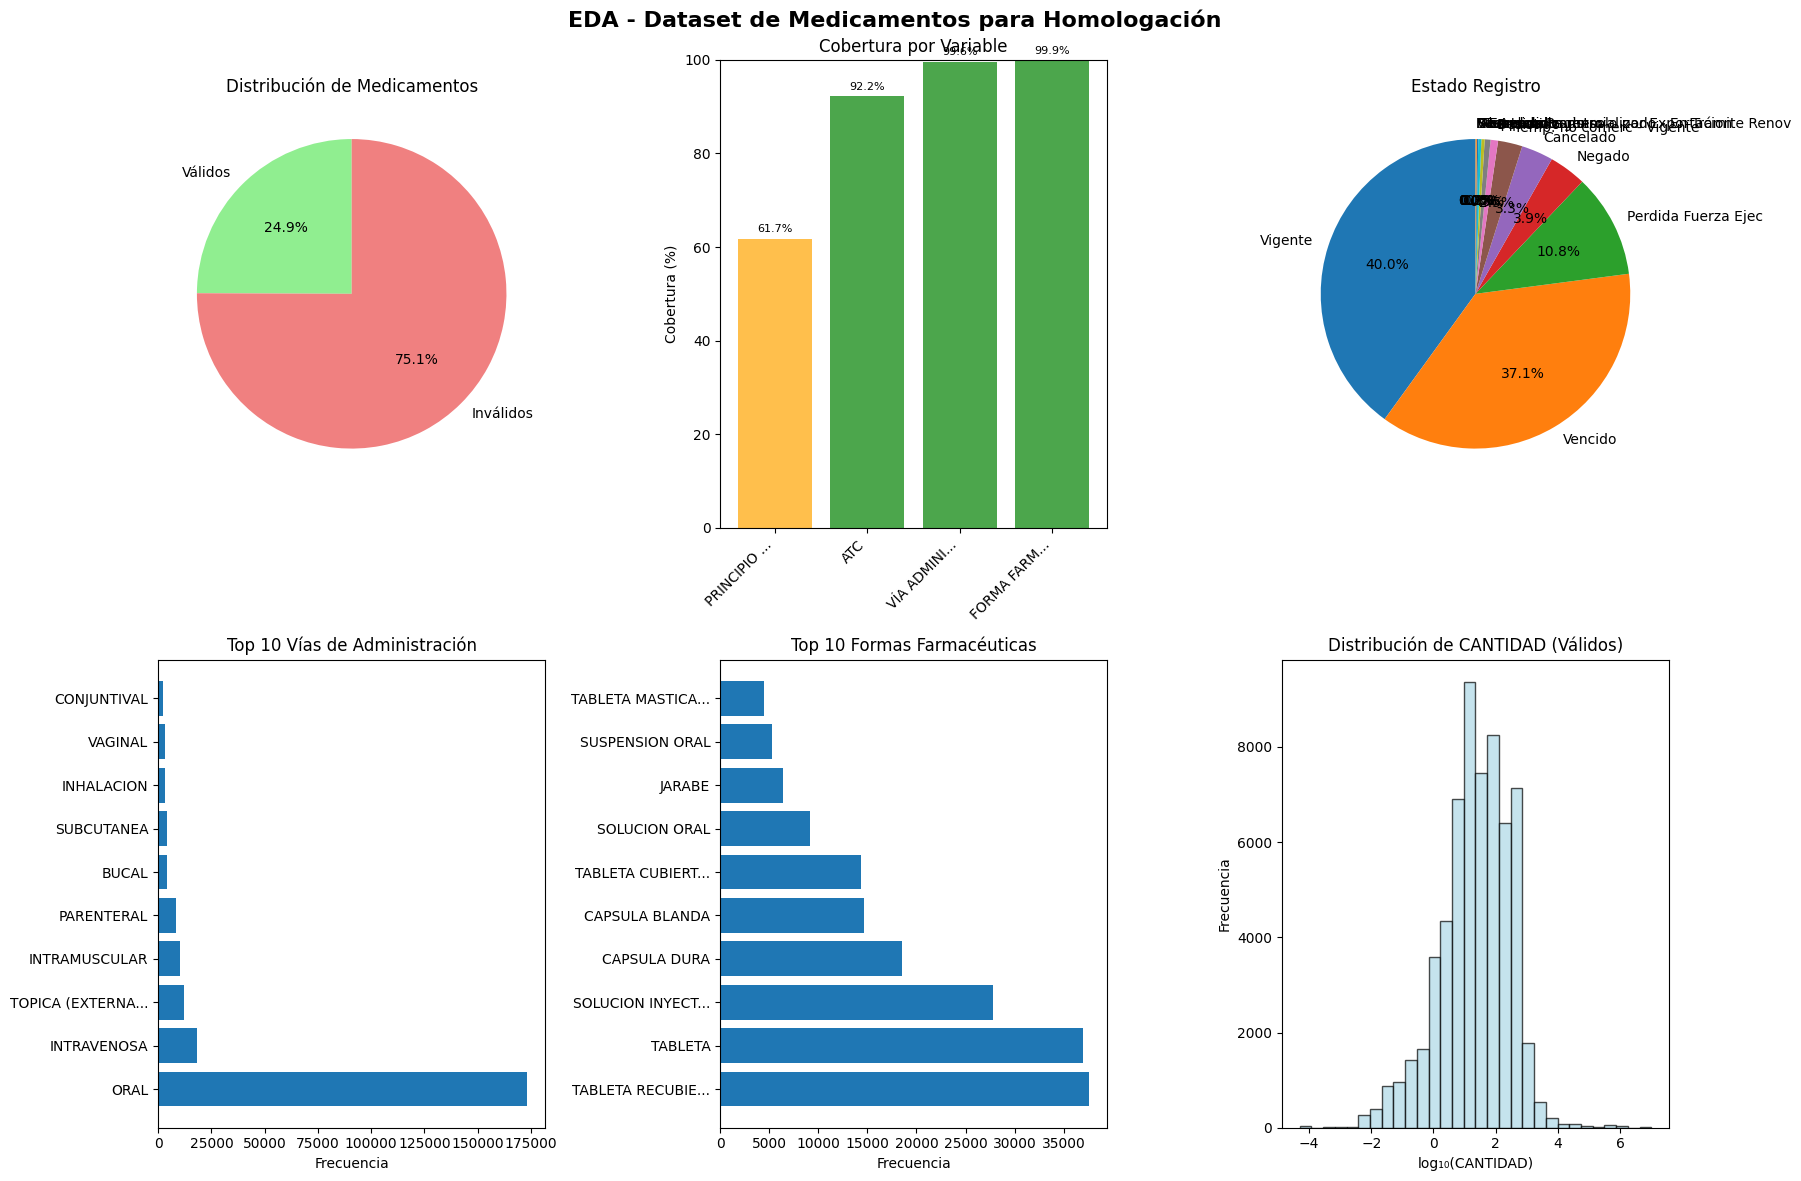

✅ Visualizaciones creadas exitosamente


In [69]:
# Ejecutar visualizaciones con los datos actuales
crear_visualizaciones_eda(df_preproc, validos, invalidos, cobertura_individual)

## 5. Exportación y Guardado de Resultados

### 5.1 Guardado del Dataset Preprocesado

Guardamos el dataset final en formatos CSV y Parquet para uso posterior:

In [70]:
# Guardar dataset preprocesado
try:
    # Guardar en formato Parquet (más eficiente)
    df_preproc.write_parquet("./data/medicamentos_preprocesados.parquet")
    print("✅ Dataset guardado como 'medicamentos_preprocesados.parquet'")
    
    # Guardar en formato CSV (más compatible)
    df_preproc.write_csv("./data/medicamentos_preprocesados.csv")
    print("✅ Dataset guardado como 'medicamentos_preprocesados.csv'")
    
    # Mostrar estadísticas finales
    print(f"\n📊 ESTADÍSTICAS FINALES:")
    print(f"   📏 Total de registros: {df_preproc.shape[0]:,}")
    print(f"   📋 Total de columnas: {df_preproc.shape[1]}")
    print(f"   💾 Tamaño en memoria: {df_preproc.estimated_size() / (1024**2):.2f} MB")
    print(f"   ✅ Medicamentos válidos: {len(validos):,} ({len(validos)/len(df_preproc)*100:.1f}%)")
    print(f"   ❌ Medicamentos inválidos: {len(invalidos):,} ({len(invalidos)/len(df_preproc)*100:.1f}%)")
    
except Exception as e:
    print(f"❌ Error guardando archivos: {e}")

✅ Dataset guardado como 'medicamentos_preprocesados.parquet'
✅ Dataset guardado como 'medicamentos_preprocesados.csv'

📊 ESTADÍSTICAS FINALES:
   📏 Total de registros: 248,635
   📋 Total de columnas: 15
   💾 Tamaño en memoria: 39.16 MB
   ✅ Medicamentos válidos: 62,006 (24.9%)
   ❌ Medicamentos inválidos: 186,629 (75.1%)
✅ Dataset guardado como 'medicamentos_preprocesados.csv'

📊 ESTADÍSTICAS FINALES:
   📏 Total de registros: 248,635
   📋 Total de columnas: 15
   💾 Tamaño en memoria: 39.16 MB
   ✅ Medicamentos válidos: 62,006 (24.9%)
   ❌ Medicamentos inválidos: 186,629 (75.1%)
